In [1]:
!pip install transformers datasets torchaudio torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model

class LieDetectionModel(nn.Module):
    def __init__(self,
             pretrained_model_name="AreejB/wav2vec2-xlsr-english-speech-emotion-recognition",
             cnn_out_channels=64,
             rnn_hidden_size=64,
             num_classes=2,
             freeze_wav2vec2=True,
             dropout_cnn=0.5,
             dropout_rnn=0.5,
             dropout_classifier=0.5):
        super().__init__()

        # Pretrained wav2vec2 model
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(pretrained_model_name)

        if freeze_wav2vec2:
            for param in self.wav2vec2.parameters():
                param.requires_grad = False

        self.layer_norm = nn.LayerNorm(self.wav2vec2.config.hidden_size)

        self.cnn = nn.Sequential(
            nn.Conv1d(self.wav2vec2.config.hidden_size, cnn_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_cnn)
        )

        self.rnn = nn.LSTM(
            input_size=cnn_out_channels,
            hidden_size=rnn_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.0
        )

        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout_classifier),
            nn.Linear(64, num_classes)
        )

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        embeddings = self.layer_norm(outputs.last_hidden_state)  # (batch, seq_len, feat_dim)

        x = embeddings.permute(0, 2, 1)  # (batch, feat_dim, seq_len)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)

        rnn_out, _ = self.rnn(x)
        pooled = torch.mean(rnn_out, dim=1)  # Time average pooling

        logits = self.classifier(pooled)
        return logits



RuntimeError: Failed to import transformers.models.wav2vec2.modeling_wav2vec2 because of the following error (look up to see its traceback):
module 'sympy' has no attribute 'core'

We tried 3 different models and get best results with just classifier head. Also we tried wav2vec2-base and wav2vec2-large but we get better results at wav2vec2-xlsr-english-speech-emotion-recognition

In [ ]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model

class LieDetectionModel(nn.Module):
    def __init__(self,
                 pretrained_model_name="AreejB/wav2vec2-xlsr-english-speech-emotion-recognition",
                 num_classes=2,
                 dropout_classifier=0.6,
                 dropout_before_pool=0.6,
                 cnn_out_channels=64,
                 cnn_kernel_size=3):
        super().__init__()

        self.wav2vec2 = Wav2Vec2Model.from_pretrained(pretrained_model_name)

        self.layer_norm = nn.LayerNorm(self.wav2vec2.config.hidden_size)
        self.dropout_before_pool = nn.Dropout(dropout_before_pool)

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=self.wav2vec2.config.hidden_size,
                      out_channels=cnn_out_channels,
                      kernel_size=cnn_kernel_size,
                      padding=cnn_kernel_size // 2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(dropout_before_pool)
        )

        self.classifier = nn.Sequential(
            nn.Linear(cnn_out_channels, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(dropout_classifier),
            nn.Linear(64, num_classes)
        )

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        embeddings = self.layer_norm(outputs.last_hidden_state)

        embeddings = self.dropout_before_pool(embeddings)

        x = embeddings.permute(0, 2, 1)
        x = self.cnn(x)

        x = x.permute(0, 2, 1)

        pooled = torch.mean(x, dim=1)
        
        logits = self.classifier(pooled)
        return logits


In [ ]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model

class LieDetectionModel(nn.Module):
    def __init__(self, pretrained_model_name="AreejB/wav2vec2-xlsr-english-speech-emotion-recognition", num_classes=2, dropout=0.3):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_classes)

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        x = self.dropout(pooled)
        logits = self.classifier(x)
        return logits


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Epoch 1/18
Train Loss: 0.6857 | Train Acc: 0.5890
Val   Loss: 0.6965 | Val   Acc: 0.6500
Epoch 2/18
Train Loss: 0.8124 | Train Acc: 0.5205
Val   Loss: 0.7468 | Val   Acc: 0.6500
Epoch 3/18
Train Loss: 0.7416 | Train Acc: 0.6301
Val   Loss: 0.7316 | Val   Acc: 0.6500
Epoch 4/18
Train Loss: 0.6680 | Train Acc: 0.6164
Val   Loss: 0.7233 | Val   Acc: 0.4500
Epoch 5/18
Train Loss: 0.6722 | Train Acc: 0.6301
Val   Loss: 0.7268 | Val   Acc: 0.3500
Epoch 6/18
Train Loss: 0.5784 | Train Acc: 0.7123
Val   Loss: 0.7137 | Val   Acc: 0.3500
Epoch 7/18
Train Loss: 0.6560 | Train Acc: 0.6849
Val   Loss: 0.6865 | Val   Acc: 0.6000
Epoch 8/18
Train Loss: 0.5947 | Train Acc: 0.7123
Val   Loss: 0.6562 | Val   Acc: 0.7500
Epoch 9/18
Train Loss: 0.6067 | Train Acc: 0.7260
Val   Loss: 0.6632 | Val   Acc: 0.7500
Epoch 10/18
Train Loss: 0.6680 | Train Acc: 0.6712
Val   Loss: 0.6643 | Val   Acc: 0.7500
Epoch 11/18
Train Loss: 0.6128 | Train Acc: 0.6849
Val   Loss: 0.6713 | Val   Acc: 0.7500
Epoch 12/18
Train L

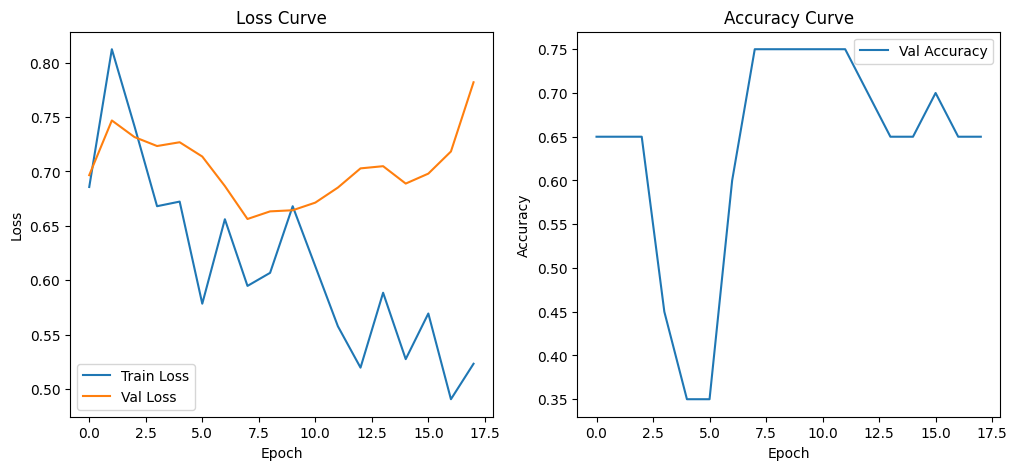

In [5]:
import os
import random
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import Wav2Vec2FeatureExtractor
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.optim.lr_scheduler import OneCycleLR



# === Settings ===
PRETRAINED_MODEL_NAME = "AreejB/wav2vec2-xlsr-english-speech-emotion-recognition"
DATA_DIR = "/content/drive/MyDrive/data_processed/"
BATCH_SIZE = 8
NUM_EPOCHS = 18
LR = 1e-4
WEIGHT_DECAY = 2e-2
SEED = 42

# === Seed for reproducibility ===
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)

# === Processor ===
processor = Wav2Vec2FeatureExtractor.from_pretrained(PRETRAINED_MODEL_NAME)

# === Audio augmentation functions ===
def add_gaussian_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def time_shift(waveform, shift_limit=0.1):
    shift_amt = int(random.uniform(-shift_limit, shift_limit) * waveform.size(1))
    return torch.roll(waveform, shifts=shift_amt, dims=1)

def change_volume(waveform, gain_db_limit=6.0):
    gain_db = random.uniform(-gain_db_limit, gain_db_limit)
    gain = 10 ** (gain_db / 20)
    return waveform * gain

def random_pitch_shift(waveform, sample_rate, n_steps=2):
    # pitch kaydırması yarım ton cinsinden -2 ile 2 arasında
    n_steps = random.uniform(-n_steps, n_steps)
    effects = [
        ['pitch', f'{n_steps * 100}'],  # cent cinsinden pitch shift
        ['rate', str(sample_rate)]
    ]
    shifted_waveform, _ = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)
    return shifted_waveform

def random_time_stretch(waveform, sample_rate, rate_range=(0.8, 1.2)):
    rate = random.uniform(*rate_range)
    effects = [
        ['speed', str(rate)],
        ['rate', str(sample_rate)]
    ]
    stretched_waveform, _ = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)
    return stretched_waveform

def random_freq_mask(spec, freq_mask_param=15):
    freq_mask = T.FrequencyMasking(freq_mask_param)
    return freq_mask(spec)

def random_time_mask(spec, time_mask_param=35):
    time_mask = T.TimeMasking(time_mask_param)
    return time_mask(spec)

# --- Spektrogram augmentasyonu (SpecAugment) ---

def spec_augment(waveform, sample_rate):
    # Önce mel spektrogram çıkar
    mel_spec = T.MelSpectrogram(sample_rate=sample_rate, n_mels=64)(waveform)
    mel_spec = random_freq_mask(mel_spec)
    mel_spec = random_time_mask(mel_spec)
    return mel_spec

# --- Komple augmentasyon pipeline ---

def augment_waveform(waveform, sample_rate):
    # Rastgele sıralı augmentasyonlar
    if random.random() < 0.5:
        waveform = add_gaussian_noise(waveform, noise_level=0.01)
    if random.random() < 0.5:
        waveform = time_shift(waveform, shift_limit=0.1)
    if random.random() < 0.5:
        waveform = change_volume(waveform, gain_db_limit=6)
    if random.random() < 0.3:
        try:
            waveform = random_pitch_shift(waveform, sample_rate)
        except Exception:
            pass  # Sox efektleri sorun çıkarırsa atla
    if random.random() < 0.3:
        try:
            waveform = random_time_stretch(waveform, sample_rate)
        except Exception:
            pass
    return waveform

# === Dataset loading ===
def load_data(data_dir, split="train"):
    audio_paths = []
    labels = []
    for label, folder in enumerate(["truth", "deceptive"]):
        folder_path = os.path.join(data_dir, split, folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".wav"):
                audio_paths.append(os.path.join(folder_path, file_name))
                labels.append(label)
    return Dataset.from_dict({"audio": audio_paths, "label": labels})


# === Custom Dataset class with augmentation ===
class AugmentedAudioDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, processor, augment=False):
        self.dataset = hf_dataset
        self.processor = processor
        self.augment = augment

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        waveform, sample_rate = torchaudio.load(item["audio"])
        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if self.augment:
            waveform = augment_waveform(waveform, sample_rate)

        waveform = waveform.squeeze(0).numpy()  # processor expects 1D np array

        inputs = self.processor(waveform, sampling_rate=sample_rate, return_tensors="pt", padding=True)

        return {
            "input_values": inputs.input_values.squeeze(0),
            "attention_mask": inputs.attention_mask.squeeze(0),
            "label": item["label"]
        }


# === Collate function ===
def collate_fn(batch):
    input_values = torch.nn.utils.rnn.pad_sequence(
        [item["input_values"] for item in batch],
        batch_first=True,
        padding_value=0
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        [item["attention_mask"] for item in batch],
        batch_first=True,
        padding_value=0
    )
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
    return {"input_values": input_values, "attention_mask": attention_mask, "labels": labels}

# === Label smoothing loss ===
def label_smoothing_loss(preds, targets, smoothing=0.02):
    confidence = 1.0 - smoothing
    log_probs = F.log_softmax(preds, dim=-1)
    nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
    smooth_loss = -log_probs.mean(dim=-1)
    loss = confidence * nll_loss + smoothing * smooth_loss
    return loss.mean()

# === Training function ===
def train_epoch(model, dataloader, optimizer, device, scaler, max_grad_norm=1.0, smoothing=0.1):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        inputs = batch["input_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        with autocast("cuda"):
            outputs = model(inputs, attention_mask=attention_mask)
            loss = label_smoothing_loss(outputs, labels, smoothing)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# === Evaluation function ===
def evaluate(model, dataloader, device, smoothing=0.0):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["input_values"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(inputs, attention_mask=attention_mask)
            loss = label_smoothing_loss(outputs, labels, smoothing)

            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def freeze_wav2vec2_layers(model, num_unfreeze_layers=2):
    # Feature extractor tamamen freeze
    for param in model.wav2vec2.feature_extractor.parameters():
        param.requires_grad = False

    # Transformer encoder katmanları freeze/unfreeze
    total_layers = len(model.wav2vec2.encoder.layers)  # genelde 12 katman
    for i, layer in enumerate(model.wav2vec2.encoder.layers):
        if i < total_layers - num_unfreeze_layers:
            for param in layer.parameters():
                param.requires_grad = False
        else:
            for param in layer.parameters():
                param.requires_grad = True

    for param in model.wav2vec2.encoder.layer_norm.parameters():
        param.requires_grad = True

# === Main training script ===
if __name__ == "__main__":
    train_dataset = load_data(DATA_DIR, "train")
    val_dataset = load_data(DATA_DIR, "val")

    train_dataset = AugmentedAudioDataset(train_dataset, processor, augment=True)
    val_dataset = AugmentedAudioDataset(val_dataset, processor, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LieDetectionModel(pretrained_model_name=PRETRAINED_MODEL_NAME)
    freeze_wav2vec2_layers(model, num_unfreeze_layers=4)
    model.to(device)


    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LR,
                              weight_decay=WEIGHT_DECAY)
    scheduler = OneCycleLR(optimizer, max_lr=LR*10, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

    scaler = GradScaler("cuda")

    best_val_loss = float("inf")
    patience_counter = 0

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scaler)
        val_loss, val_acc = evaluate(model, val_loader, device)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.show()


In [6]:
test_dataset = load_data(DATA_DIR, "test")  # "test" klasörüne göre yükle
test_dataset = AugmentedAudioDataset(test_dataset, processor, augment=False)  # Testte augmentasyon yok
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Eğitimi bitirip grafik çizdikten sonra test değerlendirme:

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")



Test Loss: 0.6322 | Test Accuracy: 0.6071


In [10]:
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import torch
import shutil
from google.colab import files

# 1. Define your pretrained model name
model_name = "AreejB/wav2vec2-xlsr-english-speech-emotion-recognition"

# 2. Load pretrained model and processor from Hugging Face
modelBase = Wav2Vec2Model.from_pretrained(model_name)
processorBase = Wav2Vec2Processor.from_pretrained(model_name)

save_dir = "/content/lie_detection_model_full"
modelBase.save_pretrained(save_dir)
processorBase.save_pretrained(save_dir)
torch.save(model.state_dict(), "/content/lie_detection_model_full/lie_detection_model.pth")

shutil.make_archive("/content/lie_detection_model_full", 'zip', save_dir)

# 7. Download the zip file
files.download("/content/lie_detection_model_full.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This part is for decode mp4 files to wav files.

In [ ]:
!apt-get install ffmpeg


In [ ]:
import os
import subprocess
import torchaudio
import torchaudio.transforms as transforms

# Path to your data on Google Drive
data_dir = '/content/drive/MyDrive/Data/'

# Function to extract audio and resample to 16kHz if necessary
def process_audio(mp4_file, output_file):
    # Extract audio from MP4 using ffmpeg
    subprocess.run(['ffmpeg', '-i', mp4_file, '-vn', '-acodec', 'pcm_s16le', '-ar', '16000', '-ac', '1', output_file])
    print(f"Extracted and saved audio to {output_file}")

    # Load the extracted audio file and check its sample rate
    waveform, sample_rate = torchaudio.load(output_file)
    print(f"Sample Rate: {sample_rate} Hz")

    # If the sample rate is not 16kHz, resample the audio
    if sample_rate != 16000:
        resampler = transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        resampled_waveform = resampler(waveform)

        # Save the resampled audio back to Google Drive
        torchaudio.save(output_file, resampled_waveform, 16000)
        print(f"Resampled audio saved to {output_file}")
    else:
        print("Audio is already at 16kHz, no resampling needed.")

In [ ]:
# Path to save processed audio files
output_dir = '/content/drive/MyDrive/data_processed/'

def process_dataset(data_dir, output_dir):
    # Iterate through each split: train, test, val
    for split in ['train', 'test', 'val']:
        for label in ['truth', 'deceptive']:
            input_dir = os.path.join(data_dir, split, label)
            output_split_dir = os.path.join(output_dir, split, label)

            # Create output directories if they don't exist
            os.makedirs(output_split_dir, exist_ok=True)

            # Iterate through each MP4 file in the folder
            for mp4_file in os.listdir(input_dir):
                if mp4_file.endswith('.mp4'):
                    mp4_file_path = os.path.join(input_dir, mp4_file)
                    output_file_path = os.path.join(output_split_dir, mp4_file.replace('.mp4', '.wav'))

                    # Process the audio file (extract, check, resample)
                    process_audio(mp4_file_path, output_file_path)

# Process the entire dataset
process_dataset(data_dir, output_dir)

Extracted and saved audio to /content/drive/MyDrive/data_processed/train/truth/trial_truth_022.wav
Sample Rate: 16000 Hz
Audio is already at 16kHz, no resampling needed.
Extracted and saved audio to /content/drive/MyDrive/data_processed/train/truth/trial_truth_001.wav
Sample Rate: 16000 Hz
Audio is already at 16kHz, no resampling needed.
Extracted and saved audio to /content/drive/MyDrive/data_processed/train/truth/trial_truth_024.wav
Sample Rate: 16000 Hz
Audio is already at 16kHz, no resampling needed.
Extracted and saved audio to /content/drive/MyDrive/data_processed/train/truth/trial_truth_025.wav
Sample Rate: 16000 Hz
Audio is already at 16kHz, no resampling needed.
Extracted and saved audio to /content/drive/MyDrive/data_processed/train/truth/trial_truth_002.wav
Sample Rate: 16000 Hz
Audio is already at 16kHz, no resampling needed.
Extracted and saved audio to /content/drive/MyDrive/data_processed/train/truth/trial_truth_019.wav
Sample Rate: 16000 Hz
Audio is already at 16kHz, no